In [18]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta


In [20]:
def prepare_stock_data(symbol='AAPL', window_size=60, split_ratio=0.8, start_date='2020-03-01'):

    end_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(symbol, start=start_date, end=end_date)
    
    if df.empty:
        raise ValueError("No data downloaded")
    
    closing_prices = df['Close'].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))
    
    X = []
    y = []
    
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i])
        y.append(scaled_data[i])
    
    X = np.array(X)
    y = np.array(y)
    
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler

try:
    X_train, X_test, y_train, y_test, scaler = prepare_stock_data(
        symbol='AAPL',
        window_size=60,
        split_ratio=0.8
    )
    
    print("Training set shape:", X_train.shape)
    print("Test set shape:", X_test.shape)
    
except Exception as e:
    print(f"Error: {e}")

[*********************100%***********************]  1 of 1 completed

Training set shape: (941, 60, 1)
Test set shape: (236, 60, 1)


In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Permute, Reshape, Multiply, AdditiveAttention, Flatten, Dropout, BatchNormalization

input_shape = (X_train.shape[1], 1)  
inputs = Input(shape=input_shape)


x = LSTM(units=50, return_sequences=True)(inputs)
x = LSTM(units=50, return_sequences=True)(x)

x = Permute((2, 1))(x)
x = Reshape((-1, X_train.shape[1]))(x)

attention = AdditiveAttention(name='attention_weight')
attention_result = attention([x, x])
multiply_layer = Multiply()([x, attention_result])

x = Permute((2, 1))(multiply_layer)
x = Reshape((-1, 50))(x)
x = Flatten()(x)
x = Dense(1)(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

lstm_model = Model(inputs=inputs, outputs=x)
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 60, 50)    │     10,400 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 60, 50)    │     20,200 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_8 (Permute) │ (None, 50, 60)    │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 50, 60)    │          0 │ permute_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 50, 60)    │         60 │ reshape_6[0][0],  │
│ (AdditiveAttention) │                   │            │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 50, 60)    │          0 │ reshape_6[0][0],  │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_9 (Permute) │ (None, 60, 50)    │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 60, 50)    │          0 │ permute_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3000)      │          0 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 1)         │      3,001 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 1)         │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dropout_44[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,665 (131.50 KB)

 Trainable params: 33,663 (131.50 KB)

 Non-trainable params: 2 (8.00 B)

In [77]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
tensorboard = TensorBoard(log_dir='./logs')
csv_logger = CSVLogger('training_log.csv')

callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1712

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - loss: 0.1710 - val_loss: 0.3416 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1476

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.1474 - val_loss: 0.3188 - learning_rate: 0.0010
Epoch 3/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1269

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.1265 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 4/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1020

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.1019 - val_loss: 0.2538 - learning_rate: 0.0010
Epoch 5/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0880

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0877 - val_loss: 0.2218 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0720 

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0720 - val_loss: 0.1989 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0620

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0619 - val_loss: 0.1866 - learning_rate: 0.0010
Epoch 8/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0515

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0514 - val_loss: 0.1646 - learning_rate: 0.0010
Epoch 9/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0431

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0429 - val_loss: 0.1358 - learning_rate: 0.0010
Epoch 10/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0351

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0349 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 11/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0283

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0282 - val_loss: 0.1141 - learning_rate: 0.0010
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0242

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0242 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 13/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0192

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0191 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 14/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0170

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0169 - val_loss: 0.0633 - learning_rate: 0.0010
Epoch 15/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0115

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0115 - val_loss: 0.0627 - learning_rate: 0.0010
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0095

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0095 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 17/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0081

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0082 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0077 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0053 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 20/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0054

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0054 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0043 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 22/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0048

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0048 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0057 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0029 - val_loss: 0.0369 - learning_rate: 0.0010
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0037 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 26/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0036

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0036 - val_loss: 7.4574e-04 - learning_rate: 0.0010
Epoch 27/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0042

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0042 - val_loss: 6.3078e-04 - learning_rate: 0.0010
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0044 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.0043 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0033 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0039 - val_loss: 0.0273 - learning_rate: 0.0010
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0039 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0028 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0035 - val_loss: 0.0028 - learning_rate: 1.

In [78]:
test_loss = lstm_model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)
y_pred = lstm_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0059
Test Loss:  0.00967532116919756
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Mean Absolute Error:  0.08806234988188216
Root Mean Square Error:  0.09836321241139159


In [79]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

def predict_next_days(model, days=4, window_size=60):
   end_date = datetime.today()
   start_date = end_date - timedelta(days=120)
   
   data = yf.download('AAPL', 
                     start=start_date.strftime('%Y-%m-%d'), 
                     end=end_date.strftime('%Y-%m-%d'), 
                     interval='1d')
   
   print(f"Data shape: {data.shape}")
   print(f"Number of trading days: {len(data['Close'])}")
   print(f"Date range: from {data.index[0]} to {data.index[-1]}")
   
   if data.empty or len(data['Close']) < window_size:
       print(f"Insufficient data. Need at least {window_size} days of data.")
       print(f"Currently have {len(data['Close'])} days of data")
       return None
       
   closing_prices = data['Close'].values
   scaler = MinMaxScaler(feature_range=(0, 1))
   scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))
   
   predicted_prices = []
   dates = []
   
   current_sequence = scaled_data[-window_size:].reshape(1, window_size, 1)
   
   for i in range(days):
       next_pred = lstm_model.predict(current_sequence, verbose=0)
       
       actual_price = scaler.inverse_transform(next_pred)[0, 0]
       predicted_prices.append(actual_price)
       
       next_date = end_date + timedelta(days=i+1)
       dates.append(next_date.strftime('%Y-%m-%d'))
       
       current_sequence = np.roll(current_sequence, -1, axis=1)
       current_sequence[0, -1, 0] = next_pred[0, 0]
   
   return list(zip(dates, predicted_prices))

try:
   predictions = predict_next_days(lstm_model, days=4)
   if predictions:
       print("\nPredicted Stock Prices:")
       print("----------------------")
       for date, price in predictions:
           print(f"Date: {date}, Predicted Price: ${price:.2f}")
           
except Exception as e:
   print(f"An error occurred: {e}")

[*********************100%***********************]  1 of 1 completed


Data shape: (81, 5)
Number of trading days: 81
Date range: from 2024-10-03 00:00:00 to 2025-01-30 00:00:00

Predicted Stock Prices:
----------------------
Date: 2025-02-01, Predicted Price: $230.65
Date: 2025-02-02, Predicted Price: $232.65
Date: 2025-02-03, Predicted Price: $233.87
Date: 2025-02-04, Predicted Price: $234.48


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, LSTM

def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(units=64, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

gru_model = build_gru_model((X_train.shape[1], 1))
gru_history = gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks_list)

gru_test_loss = gru_model.evaluate(X_test, y_test)
y_pred_gru = gru_model.predict(X_test)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))

print(f"GRU Test Loss: {gru_test_loss}")
print(f"GRU Mean Absolute Error: {mae_gru}")
print(f"GRU Root Mean Squared Error: {rmse_gru}")

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.3529 - val_loss: 0.1435 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0491 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0232 - val_loss: 0.0915 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0134 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0098 - val_loss: 0.0792 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0097 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0067 - val_loss: 0.0658 - learning_rate: 0.0010
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.0069 - val_loss: 0.0724 - learning_rate: 0.0010
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0054 - val_loss: 0.0604 - learning_rate: 0.0010
E

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization,MultiHeadAttention, GlobalAveragePooling1D,Conv1D, Add, Layer

def positional_encoding(length, depth):
    positions = tf.range(length, dtype=tf.float32)[:, tf.newaxis]
    depths = tf.range(depth, dtype=tf.float32)[tf.newaxis, :] / depth
    angle_rates = 1 / tf.pow(10000.0, depths)
    angle_rads = positions * angle_rates
    pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
    return pos_encoding

class TemporalAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.pos_encoding = positional_encoding(input_shape[1], input_shape[2])
        
    def call(self, inputs):
        return inputs + self.pos_encoding

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=256, num_layers=3):
    inputs = Input(shape=input_shape)
    
    x = TemporalAttention()(inputs)
    
    x = Conv1D(filters=head_size, kernel_size=3, padding='same')(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    
    for _ in range(num_layers):
        attention_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=head_size//num_heads,
            dropout=0.1
        )(x, x, x)
        
        x = Add()([x, attention_output])
        x = LayerNormalization(epsilon=1e-6)(x)
        
        ffn = Dense(ff_dim, activation='swish')(x)
        ffn = Dense(head_size)(ffn)
        ffn = Dropout(0.1)(ffn)
        
        x = Add()([x, ffn])
        x = LayerNormalization(epsilon=1e-6)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='swish')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='swish')(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=0.0005,
            weight_decay=0.01
        ),
        loss='mse',
        metrics=['mae']
    )
    return model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

transformer_model = build_transformer_model((X_train.shape[1], 1))
transformer_history = transformer_model.fit(
    X_train, 
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping],
    shuffle=True
)
transformer_test_loss = transformer_model.evaluate(X_test, y_test)
y_pred_transformer = transformer_model.predict(X_test)
mae_transformer = mean_absolute_error(y_test, y_pred_transformer)
rmse_transformer = np.sqrt(mean_squared_error(y_test, y_pred_transformer))

print(f"Transformer Test Loss: {transformer_test_loss}")
print(f"Transformer Mean Absolute Error: {mae_transformer}")
print(f"Transformer Root Mean Squared Error: {rmse_transformer}")

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - loss: 0.0340 - mae: 0.1436 - val_loss: 0.0018 - val_mae: 0.0375 - learning_rate: 5.0000e-04
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0039 - mae: 0.0481 - val_loss: 0.0054 - val_mae: 0.0623 - learning_rate: 5.0000e-04
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0034 - mae: 0.0466 - val_loss: 0.0037 - val_mae: 0.0504 - learning_rate: 5.0000e-04
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0029 - mae: 0.0435 - val_loss: 0.0026 - val_mae: 0.0431 - learning_rate: 5.0000e-04
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0034 - mae: 0.0469 - val_loss: 0.0034 - val_mae: 0.0484 - learning_rate: 5.0000e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0033 - mae: 0.0450
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0033 - mae: 0.0450 - val_loss: 0.0048 - val_mae: 0.0578

In [108]:
import pandas as pd

results = {
    "Model": ["LSTM", "GRU", "Transformer"],
    "Test Loss": [test_loss, gru_test_loss, transformer_test_loss[0]],
    "MAE": [mae, mae_gru, mae_transformer],
    "RMSE": [rmse, rmse_gru, rmse_transformer]
}

results_df = pd.DataFrame(results)
print(results_df)

         Model  Test Loss       MAE      RMSE
0         LSTM   0.009675  0.088062  0.098363
1          GRU   0.012975  0.102536  0.113906
2  Transformer   0.010222  0.091094  0.101103


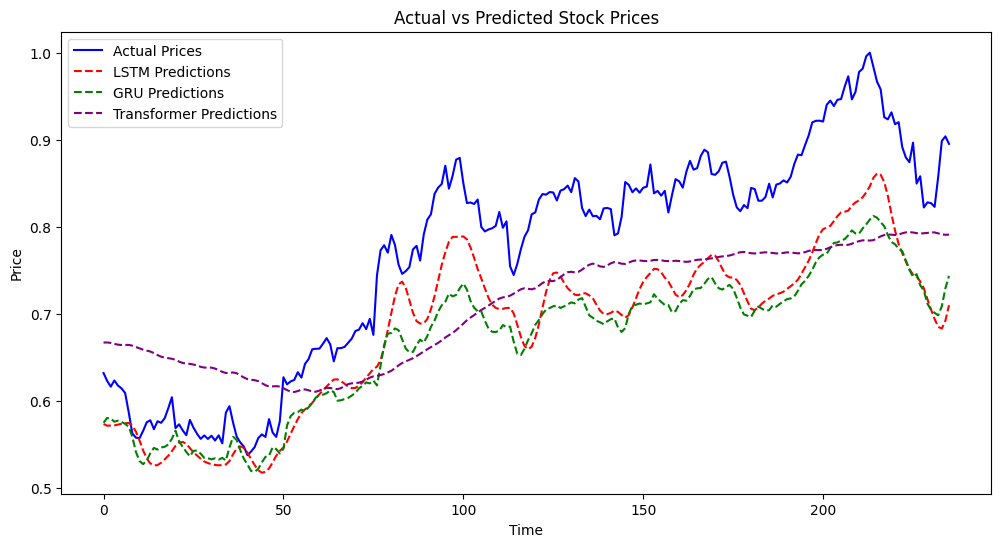

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='LSTM Predictions', color='red', linestyle='--')
plt.plot(y_pred_gru, label='GRU Predictions', color='green', linestyle='--')
plt.plot(y_pred_transformer, label='Transformer Predictions', color='purple', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()